In [ ]:
!pip install ydata-profiling
!pip install rdkit-pypi
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.9/345.9 kB 21.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.8/33.8 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 11.0 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.65.0
    Uninstalling tqdm-4.65.0:
      Successfully uninstalled tqdm-4.65.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.10.1
    Uninstalling scipy-1.10.1:
      Successfully uninstalled scipy-1.10.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
  Attempting uninstall: vision

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import shap

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor



from sklearn.metrics import make_scorer ,mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, max_error

from scipy.stats import skew

from sklearn.preprocessing import StandardScaler , FunctionTransformer

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate , cross_val_score


This train dataset contains both single-junctional OSCs with nonfullerene acceptors and tandem OSCs with nonfullerene acceptors (NFA).
The references of these different data and articles studied will be mentioned at the end of this work. 

We have collected the names of the donors and acceptors whose smiles had been lied to. ( Because one of the constraints of this project is that there was no software at our disposal allowing to find the smiles from the shortened names of molecules ) and with the help of the python library mordered which is an alternative to the software DRAGON 2.0 usually used ( which is not available anymore ) to generate descriptors ( about 1826 ) . This makes a total of about 3652 descriptors managed in our case ( 1826 for D and 1826 for A )



* The data of type D-NFA with single junction were collected and contained the quite a lot of information of which those which we retained were the name of the Donors, Acceptors, the corresponding smiles, PCE of the combinations D-A.

* Concerning the other type of data (D-NFA tandem), there were no smiles in the base. The collected data were only the PCE, the names of the D and A and we used the list of smiles at our disposal and mapped these smiles to the names of each molecule of this data.

**Note :**  You will see in this dataset some data where the names of the acceptors are not mentinonated ( and replaced by the NaN values ) . These data belong in fact to the category of D-NFA with single junction and the data were found as they are, but since it is especially the smiles which were important to generate the descriptors, these data were kept and used within the framework of our work.


How this was done will be detailed in another notebook.


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
data=pd.read_csv("/content/drive/MyDrive/train_data_with_virtualdesciptors.csv", low_memory=False)


acc_SMILES_column = data.pop('acc_SMILES')
data.insert(0, 'acc_SMILES', acc_SMILES_column)
don_SMILES_column= data.pop('don_SMILES')
data.insert(1, 'don_SMILES', don_SMILES_column)
reported_acc_column = data.pop('Reported Acceptor')
data.insert(2, 'Reported Acceptor', reported_acc_column)
reported_don_column = data.pop('Reported Donor ')
data.insert(3, 'Reported Donor ', reported_don_column)



DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, us

In [ ]:
for i in data.columns :
    
    if data[i].dtype == np.float64 :
        data[i]=data[i].astype(np.float32)
    if data[i].dtype == np.int64 :
        data[i]=data[i].astype(np.int8)
        
   

In [ ]:
pd.set_option('display.max_columns', None)
data.head()

acc_SMILES  \
0  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
1  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
2  CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...   
3  CCC1(CC)c2cc3c(cc2-c2sc(/C=C4\C(=O)c5ccccc5C4=...   
4  O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCC...   

                                          don_SMILES Reported Acceptor  \
0  CCCc1sc(-c2c3cc(-c4cc(C(=O)CC)c(-c5ccc(-c6sc(-...             IT-4F   
1  CCN1C(=O)/C(=C\c2csc(-c3ccc(-c4ccc(-c5sc(-c6cc...              ITIC   
2  CCOC(=O)/C(C#N)=C/c1ccc(-c2sc(-c3cc4c(-c5ccc(C...                Y6   
3  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...              IDIC   
4  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...               NaN   

  Reported Donor    ABC_donor  ABCGG_donor  nAcid_donor  nBase_donor  \
0       PBDT-3TCO  124.327255    84.118683            0            0   
1           PTIBT   68.613632    46.808445            0            0   
2          3BDT-5   96.424553    65.129272            0            0   
3           SM-Cl   66.015915    47.400455            0            0   
4           SM-Cl   66.015915    47.400455            0            0   

   SpAbs_A_donor  SpMax_A_donor  SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  \
0     204.028152       2.635164        5.121447    204.028152       1.324858   
1     113.422150       2.538887        4.841794    113.422150       1.350264   
2     160.252380       2.651864        5.137436    160.252380       1.335436   
3     109.669403       2.632854        5.119109    109.669403       1.305588   
4     109.669403       2.632854        5.119109    109.669403       1.305588   

   LogEE_A_donor  VE1_A_donor  VE2_A_donor  VE3_A_donor   VR1_A_donor  \
0       6.002738     8.308157     0.053949     4.851605  13929.402344   
1       5.404533     7.516350     0.089480     4.145312   2202.665527   
2       5.750998     7.829957     0.065250     4.542864  33798.625000   
3       5.376136     5.628560     0.067007     3.856085  32903.199219   
4       5.376136     5.628560     0.067007     3.856085  32903.199219   

   VR2_A_donor  VR3_A_donor  nAromAtom_donor  nAromBond_donor  nAtom_donor  \
0    90.450661    12.276125              111              117          -14   
1    26.222210     9.825655               63               63         -125   
2   281.655212    12.913082               86               92          -60   
3   391.704742    12.529557               52               54         -118   
4   391.704742    12.529557               52               54         -118   

   nHeavyAtom_donor  nSpiro_donor  nBridgehead_donor  nHetero_donor  nH_donor  \
0              -102             0                  0             33        88   
1                84             0                  0             15        47   
2               120             0                  0             22        76   
3                84             0                  0             18        54   
4                84             0                  0             18        54   

   nB_donor  nC_donor  nN_donor  nO_donor  nS_donor  nP_donor  nF_donor  \
0         0       121         0         6        21         0         6   
1         0        69         3         3         9         0         0   
2         0        98         2         4        16         0         0   
3         0        66         2         4        10         0         0   
4         0        66         2         4        10         0         0   

   nCl_donor  nBr_donor  nI_donor  nX_donor  ATS0dv_donor  ATS1dv_donor  \
0          0          0         0         6   1937.333374   1919.666626   
1          0          0         0         0    986.000000   1082.666626   
2          0          0         0         0   1317.111084   1409.333374   
3          2          0         0         2    941.654297    973.555542   
4          2          0         0         2    941.654297    973.555542   

   ATS2dv_donor  ATS3dv_donor  ATS4dv_donor  ATS5

# DATA PREPROCESSING

In [ ]:
"""profile = ProfileReport(
    data.tail(100),
    title="Profiling Report For D-NFA dataset with descriptors ",
    html={'style':{'full_width':True}}
)

profile.to_file(output_file = "data_NFA_with_descriptors-profile.html")"""


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
data.shape

In [ ]:
data.describe()

invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid value encountered in subtract
invalid valu

ABC_donor  ABCGG_donor  nAcid_donor  nBase_donor  SpAbs_A_donor  \
count  1280.0000    1280.0000       1280.0       1280.0     1280.00000   
mean         inf          inf          0.0          0.0            inf   
std      33.5000      20.5000          0.0          0.0       54.81250   
min      34.4375      27.7500          0.0          0.0       57.53125   
25%      97.8125      67.5000          0.0          0.0      160.62500   
50%     133.1250      87.6875          0.0          0.0      219.37500   
75%     137.7500      91.4375          0.0          0.0      225.12500   
max     206.2500     130.0000          0.0          0.0      342.75000   

       SpMax_A_donor  SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  \
count    1280.000000     1280.000000    1280.00000    1280.000000   
mean        2.632812        5.101562           inf       1.338867   
std         0.037872        0.103821      54.81250       0.015747   
min         2.517578        4.765625      57.53125       1.285156   
25%         2.632812        5.121094     160.62500       1.333984   
50%         2.648438        5.132812     219.37500       1.339844   
75%         2.648438        5.136719     225.12500       1.354492   
max         2.900391        5.738281     342.75000       1.382812   

       LogEE_A_donor  ...        SRW10    TSRW10       MW          AMW  \
count    1280.000000  ...  1279.000000  1279.000  1279.00  1279.000000   
mean        5.863281  ...    11.750000       inf      inf     8.953125   
std         0.404053  ...     0.250977    24.375      inf     1.101562   
min         4.730469  ...    10.218750    84.750   432.25     6.042969   
25%         5.765625  ...    11.617188   135.250  1078.00     8.296875   
50%         6.070312  ...    11.812500   151.500  1246.00     8.835938   
75%         6.105469  ...    11.875000   164.000  1420.00     9.578125   
max         6.503906  ...    12.625000   298.750  3182.00    13.093750   

         WPath    WPol  Zagreb1  Zagreb2     mZagreb2      PCE (%)  
count   1279.0  1279.0   1279.0   1279.0  1279.000000  1280.000000  
mean       inf     inf      inf      inf    19.890625     9.140625  
std        NaN     inf      inf      inf     5.125000     3.816406  
min     2392.0    50.0    170.0    206.0     6.777344     0.010002  
25%    27872.0   154.0    430.0    552.0    16.140625     6.679688  
50%    41120.0   185.0    516.0    660.0    19.562500     9.640625  
75%    58464.0   203.0    576.0    724.0    22.281250    11.750000  
max        inf   445.0   1268.0   1574.0    52.000000    18.765625  

[8 rows x 2517 columns]

In [ ]:
zero_cols = data.columns[(data == 0).all()]
len(zero_cols)
data.drop(zero_cols, axis=1, inplace=True)

In [ ]:
object_cols = data.select_dtypes(include=['object'])

"""print(len(object_cols))
for i in object_cols.columns :
    try  :
        if (sum(data[i].str.contains('missing 3D coordinate'))>20) or (sum(data[i].str.contains('min()'))>20) or (sum(data[i].str.contains('float division by zero'))>20) or (sum(data[i].str.contains('max()'))>20) :
            data.drop([i],axis=1, inplace=True)
    except :
        pass
"""

excluded_cols = ['acc_SMILES', 'don_SMILES', 'Reported Acceptor', 'Reported Donor ']
object_cols = object_cols.drop(columns=excluded_cols)

data.drop(object_cols.columns,axis=1, inplace=True)

In [ ]:
data.shape

(1280, 2320)

In [ ]:
data.head()

acc_SMILES  \
0  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
1  CCc1ccc(C2(c3ccc(CC)cc3)c3cc4c(cc3-c3sc5cc(/C=...   
2  CCc1c(/C=C2\C(=O)c3cc(F)c(F)cc3C2=C(C#N)C#N)sc...   
3  CCC1(CC)c2cc3c(cc2-c2sc(/C=C4\C(=O)c5ccccc5C4=...   
4  O=C1C2=C(C=CC=C2)C(/C1=C/C3=CC(C4(C5=CC=C(CCCC...   

                                          don_SMILES Reported Acceptor  \
0  CCCc1sc(-c2c3cc(-c4cc(C(=O)CC)c(-c5ccc(-c6sc(-...             IT-4F   
1  CCN1C(=O)/C(=C\c2csc(-c3ccc(-c4ccc(-c5sc(-c6cc...              ITIC   
2  CCOC(=O)/C(C#N)=C/c1ccc(-c2sc(-c3cc4c(-c5ccc(C...                Y6   
3  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...              IDIC   
4  CCOC(=O)/C(C#N)=C\c1cc(CC)c(-c2ccc(-c3sc(-c4cc...               NaN   

  Reported Donor    ABC_donor  ABCGG_donor  SpAbs_A_donor  SpMax_A_donor  \
0       PBDT-3TCO  124.327252    84.118682     204.028157       2.635164   
1           PTIBT   68.613631    46.808443     113.422146       2.538887   
2          3BDT-5   96.424552    65.129270     160.252377       2.651864   
3           SM-Cl   66.015914    47.400457     109.669402       2.632854   
4           SM-Cl   66.015914    47.400457     109.669402       2.632854   

   SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  LogEE_A_donor  VE1_A_donor  \
0        5.121447    204.028157       1.324858       6.002737     8.308157   
1        4.841794    113.422146       1.350264       5.404533     7.516350   
2        5.137436    160.252377       1.335436       5.750998     7.829957   
3        5.119109    109.669402       1.305588       5.376136     5.628559   
4        5.119109    109.669402       1.305588       5.376136     5.628559   

   VE2_A_donor  VE3_A_donor   VR1_A_donor  VR2_A_donor  VR3_A_donor  \
0     0.053949     4.851605  13929.401861    90.450661    12.276125   
1     0.089480     4.145312   2202.665574    26.222209     9.825655   
2     0.065250     4.542864  33798.624380   281.655203    12.913082   
3     0.067007     3.856085  32903.197765   391.704735    12.529557   
4     0.067007     3.856085  32903.197765   391.704735    12.529557   

   nAromAtom_donor  nAromBond_donor  nAtom_donor  nHeavyAtom_donor  \
0              111              117          242               154   
1               63               63          131                84   
2               86               92          196               120   
3               52               54          138                84   
4               52               54          138                84   

   nHetero_donor  nH_donor  nC_donor  nN_donor  nO_donor  nS_donor  nF_donor  \
0             33        88       121         0         6        21         6   
1             15        47        69         3         3         9         0   
2             22        76        98         2         4        16         0   
3             18        54        66         2         4        10         0   
4             18        54        66         2         4        10         0   

   nCl_donor  nX_donor  ATS0dv_donor  ATS1dv_donor  ATS2dv_donor  \
0          0         6   1937.333333   1919.666667   2830.666667   
1          0         0    986.000000   1082.666667   1586.666667   
2          0         0   1317.111111   1409.333333   2055.333333   
3          2         2    941.654321    973.555556   1367.555556   
4          2         2    941.654321    973.555556   1367.555556   

   ATS3dv_donor  ATS4dv_donor  ATS5dv_donor  ATS6dv_donor  ATS7dv_donor  \
0   2974.555556   3157.000000   3492.666667   3768.555556   3938.333333   
1   1573.888889   1482.333333   1576.666667   1452.111111   1451.000000   
2   2168.000000   2416.666667   2496.333333   2608.222222   2606.333333   
3   1406.370370   1495.333333   1524.777778   1591.925926   1520.481481   
4   1406.370370   1495.333333   1524.777778   1591.925926   1520.481481   

   ATS8dv_donor  ATS0d_donor  ATS1d_donor  ATS2d_donor  ATS3d_donor  \
0   3899.666667        982.0       1261.0       2039.0       2253.0   
1  

* Missing Values

In [ ]:
def PrintedNbrNanValues(data):
    a=dict(data.isnull().sum())
    for i,j in a.items() :
        if j>=1 :
            print(i , j)

PrintedNbrNanValues(data)

Reported Acceptor 289
ABC 1
ABCGG 1
nAcid 1
nBase 1
nAromAtom 1
nAromBond 1
nAtom 1
nHeavyAtom 1
nSpiro 1
nBridgehead 1
nHetero 1
nH 1
nB 1
nC 1
nN 1
nO 1
nS 1
nP 1
nF 1
nCl 1
nBr 1
nI 1
nX 1
ATS0dv 1
ATS1dv 1
ATS2dv 1
ATS3dv 1
ATS4dv 1
ATS5dv 1
ATS6dv 1
ATS7dv 1
ATS8dv 1
ATS0d 1
ATS1d 1
ATS2d 1
ATS3d 1
ATS4d 1
ATS5d 1
ATS6d 1
ATS7d 1
ATS8d 1
ATS0Z 1
ATS1Z 1
ATS2Z 1
ATS3Z 1
ATS4Z 1
ATS5Z 1
ATS6Z 1
ATS7Z 1
ATS8Z 1
ATS0m 1
ATS1m 1
ATS2m 1
ATS3m 1
ATS4m 1
ATS5m 1
ATS6m 1
ATS7m 1
ATS8m 1
ATS0v 1
ATS1v 1
ATS2v 1
ATS3v 1
ATS4v 1
ATS5v 1
ATS6v 1
ATS7v 1
ATS8v 1
ATS0se 1
ATS1se 1
ATS2se 1
ATS3se 1
ATS4se 1
ATS5se 1
ATS6se 1
ATS7se 1
ATS8se 1
ATS0pe 1
ATS1pe 1
ATS2pe 1
ATS3pe 1
ATS4pe 1
ATS5pe 1
ATS6pe 1
ATS7pe 1
ATS8pe 1
ATS0are 1
ATS1are 1
ATS2are 1
ATS3are 1
ATS4are 1
ATS5are 1
ATS6are 1
ATS7are 1
ATS8are 1
ATS0p 1
ATS1p 1
ATS2p 1
ATS3p 1
ATS4p 1
ATS5p 1
ATS6p 1
ATS7p 1
ATS8p 1
ATS0i 1
ATS1i 1
ATS2i 1
ATS3i 1
ATS4i 1
ATS5i 1
ATS6i 1
ATS7i 1
ATS8i 1
AATS0dv 1
AATS1dv 1
AATS2dv 1
AATS3dv 1
AAT

In [ ]:
data.dropna(subset=['ATSC7v'], inplace=True)
PrintedNbrNanValues(data)

Reported Acceptor 288


###  correlation matrix

In [ ]:
corr_matrix = data.corr()


In [ ]:
corr_matrix

ABC_donor  ABCGG_donor  SpAbs_A_donor  SpMax_A_donor  \
ABC_donor        1.000000     0.995606       0.999799       0.730261   
ABCGG_donor      0.995606     1.000000       0.995234       0.736810   
SpAbs_A_donor    0.999799     0.995234       1.000000       0.727221   
SpMax_A_donor    0.730261     0.736810       0.727221       1.000000   
SpDiam_A_donor   0.752526     0.746564       0.750581       0.923435   
...                   ...          ...            ...            ...   
WPol             0.181236     0.184774       0.181823       0.159337   
Zagreb1          0.172315     0.176447       0.173164       0.155500   
Zagreb2          0.181588     0.185111       0.182251       0.159202   
mZagreb2         0.146614     0.152504       0.147991       0.144451   
PCE (%)          0.429094     0.429803       0.426117       0.335084   

                SpDiam_A_donor  SpAD_A_donor  SpMAD_A_donor  LogEE_A_donor  \
ABC_donor             0.752526      0.999799       0.672889       0.979180   
ABCGG_donor           0.746564      0.995234       0.640942       0.976154   
SpAbs_A_donor         0.750581      1.000000       0.676290       0.978358   
SpMax_A_donor         0.923435      0.727221       0.672789       0.800928   
SpDiam_A_donor        1.000000      0.750581       0.665597       0.819279   
...                        ...           ...            ...            ...   
WPol                  0.132695      0.181823       0.173131       0.187023   
Zagreb1               0.127448      0.173164       0.170720       0.179654   
Zagreb2               0.133101      0.182251       0.175337       0.188043   
mZagreb2              0.114646      0.147991       0.156019       0.156567   
PCE (%)               0.403379      0.426117       0.236111       0.440152   

                VE1_A_donor  VE2_A_donor  VE3_A_donor  VR1_A_donor  \
ABC_donor          0.916415    -0.910561     0.976147     0.036649   
ABCGG_donor        0.919668    -0.905631     0.975261     0.032315   
SpAbs_A_donor      0.914651    -0.910024     0.975085     0.036065   
SpMax_A_donor      0.665400    -0.828620     0.772510     0.197406   
SpDiam_A_donor     0.653068    -0.869097     0.783759     0.171824   
...                     ...          ...          ...          ...   
WPol               0.200491    -0.156259     0.194916     0.006680   
Zagreb1            0.191737    -0.150022     0.187393     0.004643   
Zagreb2            0.201078    -0.157291     0.195984     0.005537   
mZagreb2           0.165158    -0.132067     0.163342     0.000570   
PCE (%)            0.411889    -0.435995     0.437016     0.040734   

                VR2_A_donor  VR3_A_donor  nAromAtom_donor  nAromBond_donor  \
ABC_donor          0.036649     0.787257         0.986482         0.982944   
ABCGG_donor        0.032315     0.776306         0.972764         0.968859   
SpAbs_A_donor      0.036065     0.787184         0.986658         0.982971   
SpMax_A_donor      0.197406     0.785575         0.708199         0.725816   
SpDiam_A_donor     0.171824     0.813915         0.745438         0.764406   
...                     ...          ...              ...              ...   
WPol               0.006680     0.119543         0.181381         0.182515   
Zagreb1            0.004643     0.113140         0.173075         0.174940   
Zagreb2            0.005537     0.119994         0.182199         0.183407   
mZagreb2           0.000570     0.095949         0.147045         0.150274   
PCE (%)            0.040734     0.386910         0.412423         0.408335   

                nAtom_donor  nHeavyAtom_donor  nHetero_donor  nH_donor  \
ABC_donor          0.976552          0.999531       0.894694  0.850923   
ABCGG_donor        0.977775          0.996328       0.899343  0.859533   
SpAbs_A_donor      0.979270          0.999535       0.890023  0.857998   
SpMax_A_donor      0.675306          0.723545       0.665130  0.533638   
SpDiam_A_donor     0.694527          0.748401       0.734697  0.54

In [ ]:

corr_matrix = corr_matrix.abs()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
to_drop = [c for c in corr_matrix.columns if  c != 'PCE (%)' and any(corr_matrix[c] >= 0.8)]
print(f"{len(to_drop)}/{len(corr_matrix)}")
data = data.drop(columns=to_drop)

1837/2316


In [ ]:
data.shape

(1279, 483)

In [ ]:
def identify_correlated(df, threshold):
    """
    A function to identify highly correlated features.
    """
    matrix = df.corr().abs()
    mask = np.triu(np.ones_like(matrix, dtype=bool))
    reduced_matrix = matrix.mask(mask)
    to_drop = [c for c in reduced_matrix.columns if any(reduced_matrix[c] > threshold)]
    return to_drop


In [ ]:
cols = ['acc_SMILES', 'don_SMILES', 'Reported Acceptor', 'Reported Donor ','PCE (%)']
X = data.drop(columns=cols)
y = data['PCE (%)']

### Mutual Information:

In [ ]:
from sklearn.feature_selection import mutual_info_regression


mutual_info = mutual_info_regression(X, y)
top_features = mutual_info.argsort()[::-1][:100]
X = X.iloc[:, top_features]

### Recursive Feature Elimination

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

model = RandomForestRegressor(random_state=42)

cv = KFold(n_splits=5)
selector = RFECV(model, cv=cv)
selector.fit(X, y)
selector.transform(X)

array([[ 1.47741530e-02, -1.59368285e-01,  1.54342654e-01, ...,
        -1.91828125e+00,  2.00000000e+00,  9.23365198e+00],
       [ 8.61122435e-03, -1.63198816e-01,  1.68442870e-01, ...,
        -1.64225771e+00,  5.00000000e+00,  8.71218595e+00],
       [ 1.06752923e-02,  4.57830511e-02,  6.45255056e-02, ...,
         0.00000000e+00,  2.00000000e+00,  1.10114345e+01],
       ...,
       [ 1.62434025e-02, -3.10254910e-01,  1.18075413e-01, ...,
        -1.91828125e+00,  8.00000000e+00,  9.23365198e+00],
       [ 1.62434025e-02, -3.10254910e-01,  1.18075413e-01, ...,
        -1.64225771e+00,  8.00000000e+00,  8.71218595e+00],
       [ 1.62434025e-02, -3.10254910e-01,  1.18075413e-01, ...,
        -1.55267782e+00,  8.00000000e+00,  1.00165754e+01]])

In [ ]:
print('Optimal number of features: {}'.format(selector.n_features_))
print(np.where(selector.support_ == False)[0])

X.drop(X.columns[np.where(selector.support_ == False)[0]], axis=1, inplace=True)

Optimal number of features: 70
[ 4  5 11 16 17 18 21 29 31 33 34 36 40 45 46 49 50 52 53 56 58 67 69 70
 74 78 79 85 93 97]


In [ ]:
X

AETA_eta_B_donor  MATS4are_donor  MATS3m_donor  mZagreb2_donor  \
0             0.014774       -0.159368      0.154343       33.222222   
1             0.008611       -0.163199      0.168443       17.944444   
2             0.010675        0.045783      0.064526       26.277778   
3             0.013750        0.015193      0.191935       18.777778   
4             0.013750        0.015193      0.191935       18.777778   
...                ...             ...           ...             ...   
1275          0.016243       -0.310255      0.118075       18.944444   
1276          0.016243       -0.310255      0.118075       18.944444   
1277          0.016243       -0.310255      0.118075       18.944444   
1278          0.016243       -0.310255      0.118075       18.944444   
1279          0.016243       -0.310255      0.118075       18.944444   

      GATS7v_donor  GATS8i_donor  JGI10_donor  JGT10_donor  GATS6d_donor  \
0         0.943153      0.959892     0.006240     0.423804      1.071128   
1         0.849996      1.076119     0.005913     0.373576      0.869968   
2         0.923627      1.097321     0.006415     0.389667      1.119467   
3         0.897496      1.106614     0.006194     0.434266      1.050889   
4         0.897496      1.106614     0.006194     0.434266      1.050889   
...            ...           ...          ...          ...           ...   
1275      0.992421      1.236228     0.007445     0.448028      1.059981   
1276      0.992421      1.236228     0.007445     0.448028      1.059981   
1277      0.992421      1.236228     0.007445     0.448028      1.059981   
1278      0.992421      1.236228     0.007445     0.448028      1.059981   
1279      0.992421      1.236228     0.007445     0.448028      1.059981   

      GATS3are_donor  AMW_donor  GATS4m_donor  GATS4v_donor  MATS5are_donor  \
0           0.919031  10.008521      1.170640      0.840846       -0.075670   
1           0.964103   9.565728      1.172133      0.982564       -0.189496   
2           0.765771   9.470070      1.177592      0.869058       -0.015447   
3           0.797388   9.623672      1.251896      0.940028       -0.079738   
4           0.797388   9.623672      1.251896      0.940028       -0.079738   
...              ...        ...           ...           ...             ...   
1275        0.653359  11.768723      1.111799      0.789861       -0.009623   
1276        0.653359  11.768723      1.111799      0.789861       -0.009623   
1277        0.653359  11.768723      1.111799      0.789861       -0.009623   
1278        0.653359  11.768723      1.111799      0.789861       -0.009623   
1279        0.653359  11.768723      1.111799      0.789861       -0.009623   

      GATS3d_donor  MATS4m_donor  JGI8_donor  MATS4s_donor  GATS3m_donor  \
0         0.937557     -0.046018    0.013590     -0.124437      0.970666   
1         1.201662     -0.129816    0.008662     -0.027722      0.894773   
2         0.899591      0.004011    0.012262      0.138254      1.112423   
3         0.986885     -0.093430    0.012757      0.148846      0.934418   
4         0.986885     -0.093430    0.012757      0.148846      0.934418   
...            ...           ...         ...           ...           ...   
1275      1.090705     -0.070384    0.011744     -0.312545      0.968393   
1276      1.090705     -0.070384    0.011744     -0.312545      0.968393   
1277      1.090705     -0.070384    0.011744     -0.312545      0.968393   
1278      1.090705     -0.070384    0.011744     -0.312545      0.968393   
1279      1.090705     -0.070384    0.011744     -0.312545      0.968393   

      MATS5s_donor  ATSC3m_donor  TopoPSA(NO)  MATS2are_donor  GATS7are_donor  \
0        -0.047801   6510.282452       129.30        0.061083        0.905798   
1        -0.077747   3270.091664       129.30        0.138005        0.529458   
2        -0.047151   2088.565719       164.94        0.165455        0.658060   
3        -0.056388   4585.534926       129

### SHAP (SHapley Additive exPlanations)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


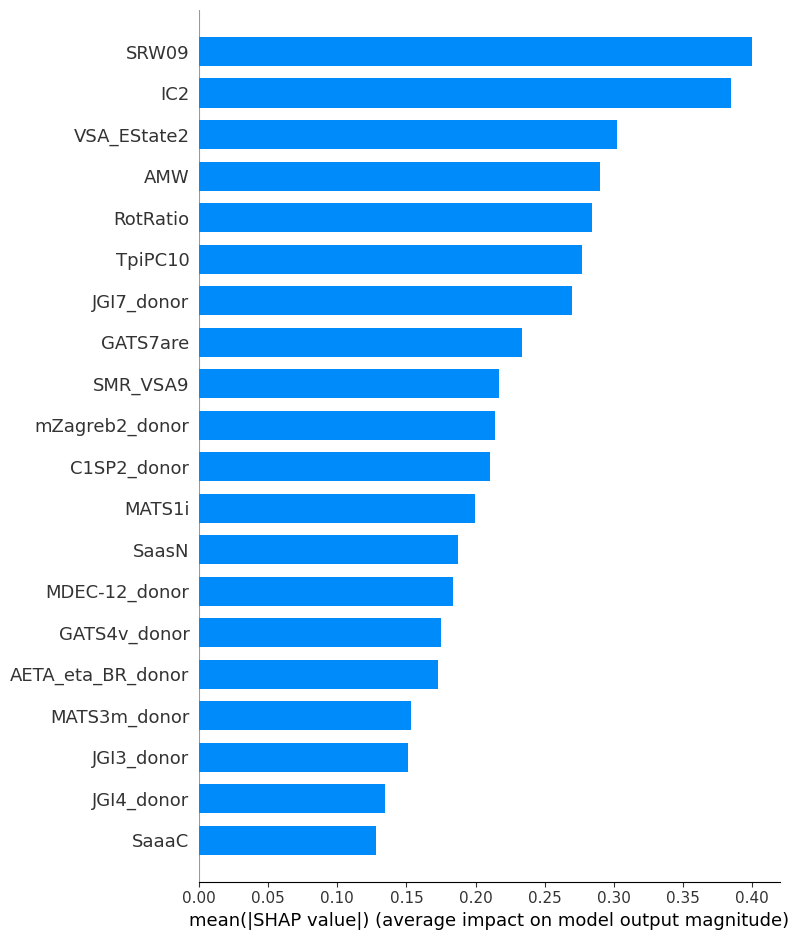

In [ ]:
# With XGBOOST
model = xgb.XGBRegressor(objective='reg:squarederror')
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)
# Select the top 5 features based on mean absolute SHAP values
mean_shap_values = shap_values.abs.mean(axis=0)
top_features = mean_shap_values.argsort()[::-1][:5]
feature_name_by_xg = X.iloc[:, top_features].columns

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

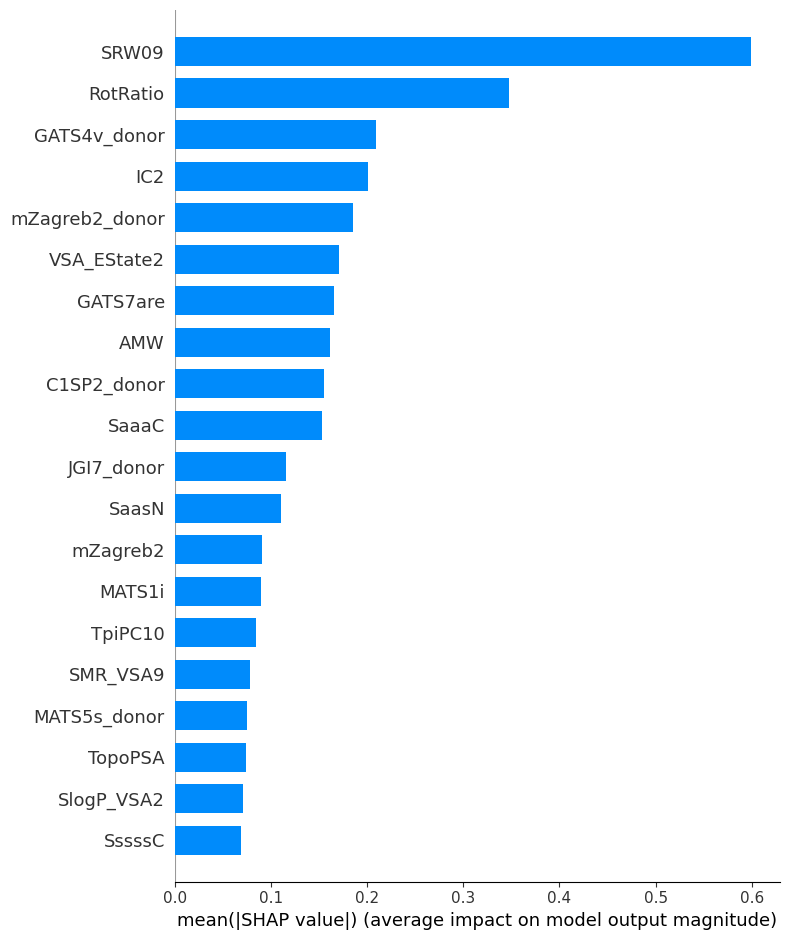

In [ ]:
# # With Random Forest 
model = RandomForestRegressor(random_state=42)
model.fit(X, y)

explainer = shap.Explainer(model)
shap_values = explainer(X)

shap.summary_plot(shap_values, X, plot_type='bar', show=False)

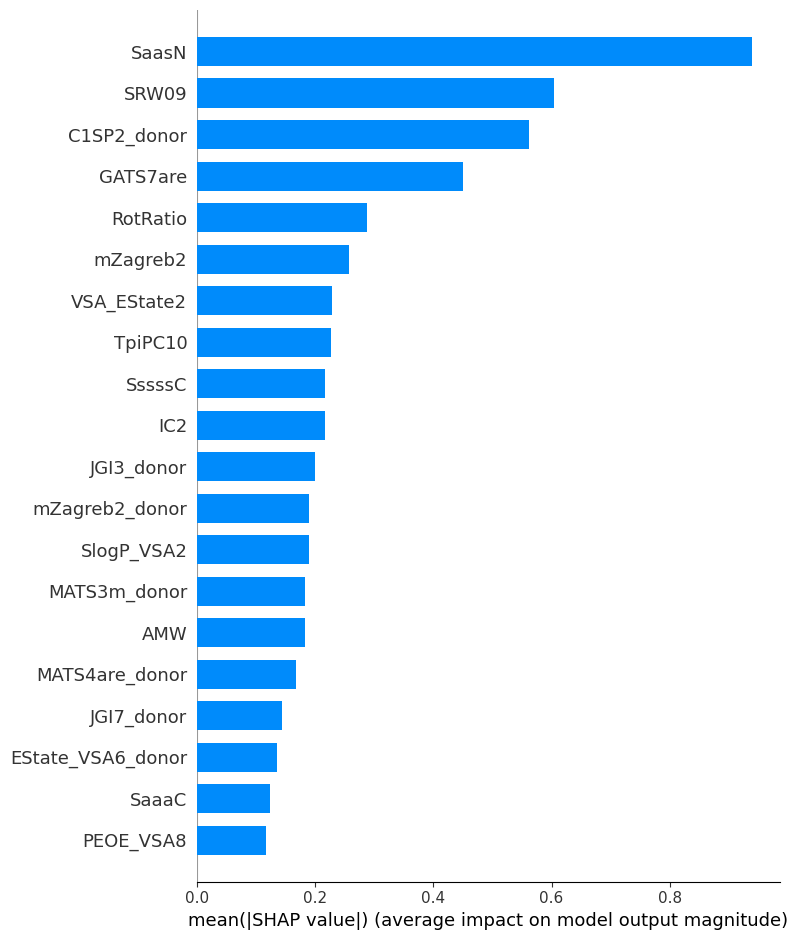

In [ ]:
# With decesionTree
from sklearn.tree import DecisionTreeRegressor
# Entraînement du modèle
model = DecisionTreeRegressor(random_state=0)
model.fit(X, y)

# Calcul des valeurs d'importance avec SHAP
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Identificaton des features à supprimer
#feature_importance = shap_values.mean(axis=0)
#least_important = feature_importance.argsort()[:5]

# Display a barplot which show the importance of each features
shap.summary_plot(shap_values, X, plot_type='bar', show=False)

In [ ]:
shap_values

.values =
array([[-1.65851208e-02,  6.46490980e-02, -8.36724591e-02, ...,
         1.24853652e-01,  3.33575834e-01, -5.87004616e-02],
       [-5.16667604e-04,  1.32963460e-01,  3.21243591e-01, ...,
        -1.65789077e-02,  3.45917165e-02, -9.39103218e-02],
       [ 2.73516904e-01,  2.72814142e-02, -2.23124181e+00, ...,
        -2.65270483e-01,  2.59538019e-01,  1.14690964e-01],
       ...,
       [-1.34775710e-02,  7.34968878e-02, -1.42090372e-01, ...,
         5.97982772e-02,  1.33029445e-01, -7.66474857e-02],
       [-1.43438635e-02,  1.36097881e-01, -8.22295099e-01, ...,
        -1.19156682e-01,  1.44450840e-01, -8.20554731e-02],
       [-1.40381806e-02,  7.07372481e-02, -1.14954730e-01, ...,
        -1.30993912e-01,  3.31219556e-01, -9.00691209e-02]])

.base_values =
array([[9.14146755],
       [9.14146755],
       [9.14146755],
       ...,
       [9.14146755],
       [9.14146755],
       [9.14146755]])

.data =
array([[ 1.47741530e-02, -1.59368285e-01,  1.54342654e-01, ...,
     

# Model Construction 

To select the appropriate regression model , we must train and validate differents models on our train/validation data and compare the metrics

* XGBoost
* Random Forest
* Desicion Trees
* K-nearest neighbors

# MODEL TEST (APPLICATION)


664 unique acceptors and 235 unique donors were identified. And so 664*235 combinations were generated, the corresponding smiles were identified and the descriptors were calculated to constitute our test dataset.